In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras

## Loading the data

In [2]:
folder_path = '../data/clean/'
data = pd.read_csv(os.path.join(folder_path, 'X_train.csv'), index_col=0)
target = pd.read_csv(os.path.join(folder_path, 'Y_train.csv'), index_col=0)
prdtype = pd.read_csv('../data/prdtype.csv', index_col='prdtypecode')
target = prdtype.loc[target['prdtypecode'], 'prdtypedesignation']

In [4]:
data.head()

,designation,description,productid,imageid,language,designation_translated,description_translated
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,de,Olivia : Carnet personnalisé / 150 pages / gri...,NaN
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,fr,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,fr,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,en,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN
4,La Guerre Des Tuques,Luc a des idées de grandeur. Il veut organiser...,278535884,1077757786,fr,La Guerre Des Tuques,Luc a des idées de grandeur. Il veut organiser...


## Tokenize translated text

In [107]:
#tokenize multiple columns
from nltk.tokenize import word_tokenize

colnames = ['designation', 'description']#['designation_translated', 'description_translated'] #
merged_txt = data[colnames].apply(lambda row: ' '.join(s for s in row if isinstance(s, str)), axis=1)
data['tokens'] = merged_txt.str.lower().apply(lambda x: word_tokenize(x, language='french'))

## Remove stopwords and punctuation from tokens

In [29]:
def remove_wordsubset(words, wordsubset):
    #remove words in wordsubset
    words_filtered = [word for word in words if word not in wordsubset]
    return words_filtered

def remove_token_duplicates(words):
    #remove duplicated tokens, keeping the same order
    wordset = set()
    words_filtered = [wordset.add(word) or word for word in words if word not in wordset]
    return words_filtered

In [8]:
#Removing stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('french'))
data['tokens'] = data['tokens'].apply(lambda x: remove_wordsubset(x, stop_words))

In [108]:
#Removing puntuation
punctuations = [",", ".", "``", "@", "*", "(", ")", "...", "!", "?", "-", "_", ">", "<", ":", "/", "=", "--", "©", "~", ";", "\\", "\\\\"]
data['tokens'] = data['tokens'].apply(lambda x: remove_wordsubset(x, punctuations))

In [109]:
#Removing duplicated tokens
data['tokens'] = data['tokens'].apply(lambda x: remove_token_duplicates(x))

In [110]:
#Converting list of tokens to string
data['tokens'] = data['tokens'].apply(lambda x:  ' '.join(x))

## Further cleaning with Regex?

In [ ]:
#import re

#remove words shorter than 4 characters
#data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"\b\w{1,2}\b(?!°)", ' ', x))

#remove numbers
#data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"[0-9]+", ' ', x))

#remove any word that has no vowel
#data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"\b(?![^aeiouyáéíóúàèìòùâêîôûäëïöü])[^\s]+\b", ' ', x))

#removing extra spaces
#data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x.split()))

## Function to plot results

In [33]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_classification_results(y_true, y_pred, index=None):
    #Print evaluation metrics
    print(classification_report(y_true, y_pred))
    
    #Build confusion matrix
    conf_mat = round(pd.crosstab(y_true, y_pred, rownames=['Classes reelles'], colnames=['Classes predites'], normalize='columns')*100)

    #in case labels are encoded, update with the original lables provided
    if index is not None:
        conf_mat.index = index
        conf_mat.columns = index
        
    #hierarchical clustering to find optimal order of labels
    Z = linkage(conf_mat, 'ward')
    order = leaves_list(Z)
    conf_mat = conf_mat.iloc[order, order]

    #plot confusion matrix as heatmap
    plt.figure(figsize=(15,12))
    sns.heatmap(conf_mat, annot=round(conf_mat,12), center=50, cmap=sns.color_palette('rocket',  as_cmap=True))
    plt.show()
    
    return plt

## Creating train and test sets

In [111]:
from sklearn.model_selection import train_test_split

#Creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['tokens'], target, test_size=0.2, random_state=123, stratify=target)

## Vectorization layer

<Axes: >

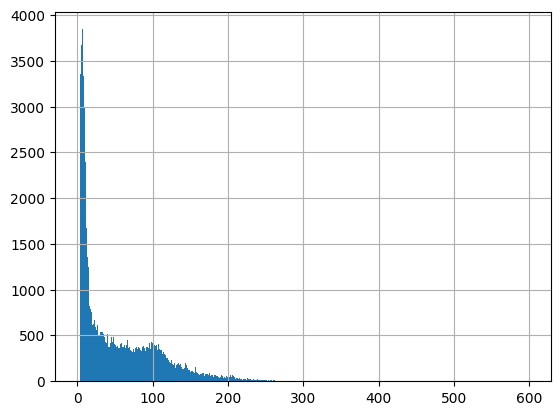

In [112]:
data['tokens'].str.split().apply(len).hist(bins=range(0, 600, 1))

In [113]:
data['tokens'][data['tokens'].str.split().apply(len)==1]
data['designation'][data['tokens'].str.split().apply(len)==1]

80487    Nadau ! Nadau !
Name: designation, dtype: object

In [114]:
from sklearn.preprocessing import LabelEncoder

#Encoding classes as integers
encoder = LabelEncoder()
y_train_class = encoder.fit_transform(y_train)
y_test_class = encoder.transform(y_test)

In [120]:
from keras.models import Sequential, Model
from keras.layers import Input, TextVectorization, Embedding, Flatten, Dense, Conv1D, Conv2D, Dropout, MaxPooling1D, Reshape, GlobalAveragePooling1D
from keras.layers import LSTM, GRU
from keras.metrics import F1Score

#Size of vocabulary
max_len = 600 #max length of senetnces in tokens
max_tok = 140000 #max number of different tokens
outvec_size = 300
n_class = len(np.unique(y_train_class)) #number of classes for classification layer
f1_score = F1Score(average='weighted', threshold=None, name='f1_score', dtype=None) #Can't yet make that one work

#Building simple dense model with embedding
model = Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(TextVectorization(max_tokens=max_tok, output_mode='int', output_sequence_length=max_len, standardize="lower_and_strip_punctuation", split='whitespace'))
model.add(Embedding(input_dim=max_tok, output_dim=outvec_size, input_length=max_len))

model.add(Dropout(rate=0.5))

#model.add(GlobalAveragePooling1D())

#model.add(GRU(128))#model.add(LSTM(128))
#model.add(Dropout(rate=0.2))

#model.add(Reshape((max_len, 1, outvec_size)))
#model.add(Conv2D(filters=64, kernel_size=(3, 1), activation='relu'))
#model.add(Dropout(rate=0.2))

#model.add(Conv1D(outvec_size, 5, activation='relu')) #Conv1D applies across the sequences and then sum over embedding dimension
#model.add(MaxPooling1D(3))
#model.add(Conv1D(outvec_size//2, 7, activation='relu'))
#model.add(Dropout(rate=0.2))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))

#model.add(Dense(units=128, activation='relu'))
#model.add(Dropout(rate=0.2))

model.add(Dense(units=n_class, activation='softmax'))

#Creating the vocabulary for the tokenizer before training
model.layers[0].adapt(X_train)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [121]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_13 (Tex  (None, 600)               0         
 tVectorization)                                                 
                                                                 
 embedding_13 (Embedding)    (None, 600, 300)          42000000  
                                                                 
 dropout_22 (Dropout)        (None, 600, 300)          0         
                                                                 
 flatten_12 (Flatten)        (None, 180000)            0         
                                                                 
 dense_21 (Dense)            (None, 64)                11520064  
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                     

In [122]:
history = model.fit(X_train, y_train_class, epochs=5, batch_size=64, validation_split=0.1)

Epoch 1/5
956/956 [==============================] - 201s 210ms/step - loss: 2.1945 - accuracy: 0.3497 - val_loss: 1.0236 - val_accuracy: 0.7039
Epoch 2/5
956/956 [==============================] - 211s 221ms/step - loss: 0.7222 - accuracy: 0.7876 - val_loss: 0.6833 - val_accuracy: 0.8035
Epoch 3/5
956/956 [==============================] - 202s 212ms/step - loss: 0.2848 - accuracy: 0.9174 - val_loss: 0.7137 - val_accuracy: 0.8091
Epoch 4/5
956/956 [==============================] - 188s 196ms/step - loss: 0.1410 - accuracy: 0.9620 - val_loss: 0.7462 - val_accuracy: 0.8150
Epoch 5/5
956/956 [==============================] - 207s 216ms/step - loss: 0.0810 - accuracy: 0.9793 - val_loss: 0.8475 - val_accuracy: 0.8117


531/531 [==============================] - 4s 7ms/step
              precision    recall  f1-score   support

           0       0.89      0.75      0.81       336
           1       0.76      0.76      0.76       165
           2       0.95      0.94      0.95       791
           3       0.88      0.84      0.86       161
           4       0.96      0.83      0.89       166
           5       0.75      0.55      0.63       153
           6       0.68      0.85      0.75       534
           7       0.92      0.93      0.92       998
           8       0.64      0.52      0.58       414
           9       0.85      0.89      0.87      1009
          10       0.68      0.72      0.70       502
          11       0.73      0.82      0.77       284
          12       1.00      0.99      0.99       174
          13       0.69      0.60      0.64       974
          14       0.86      0.94      0.90       861
          15       0.67      0.81      0.73       955
          16       0.83   

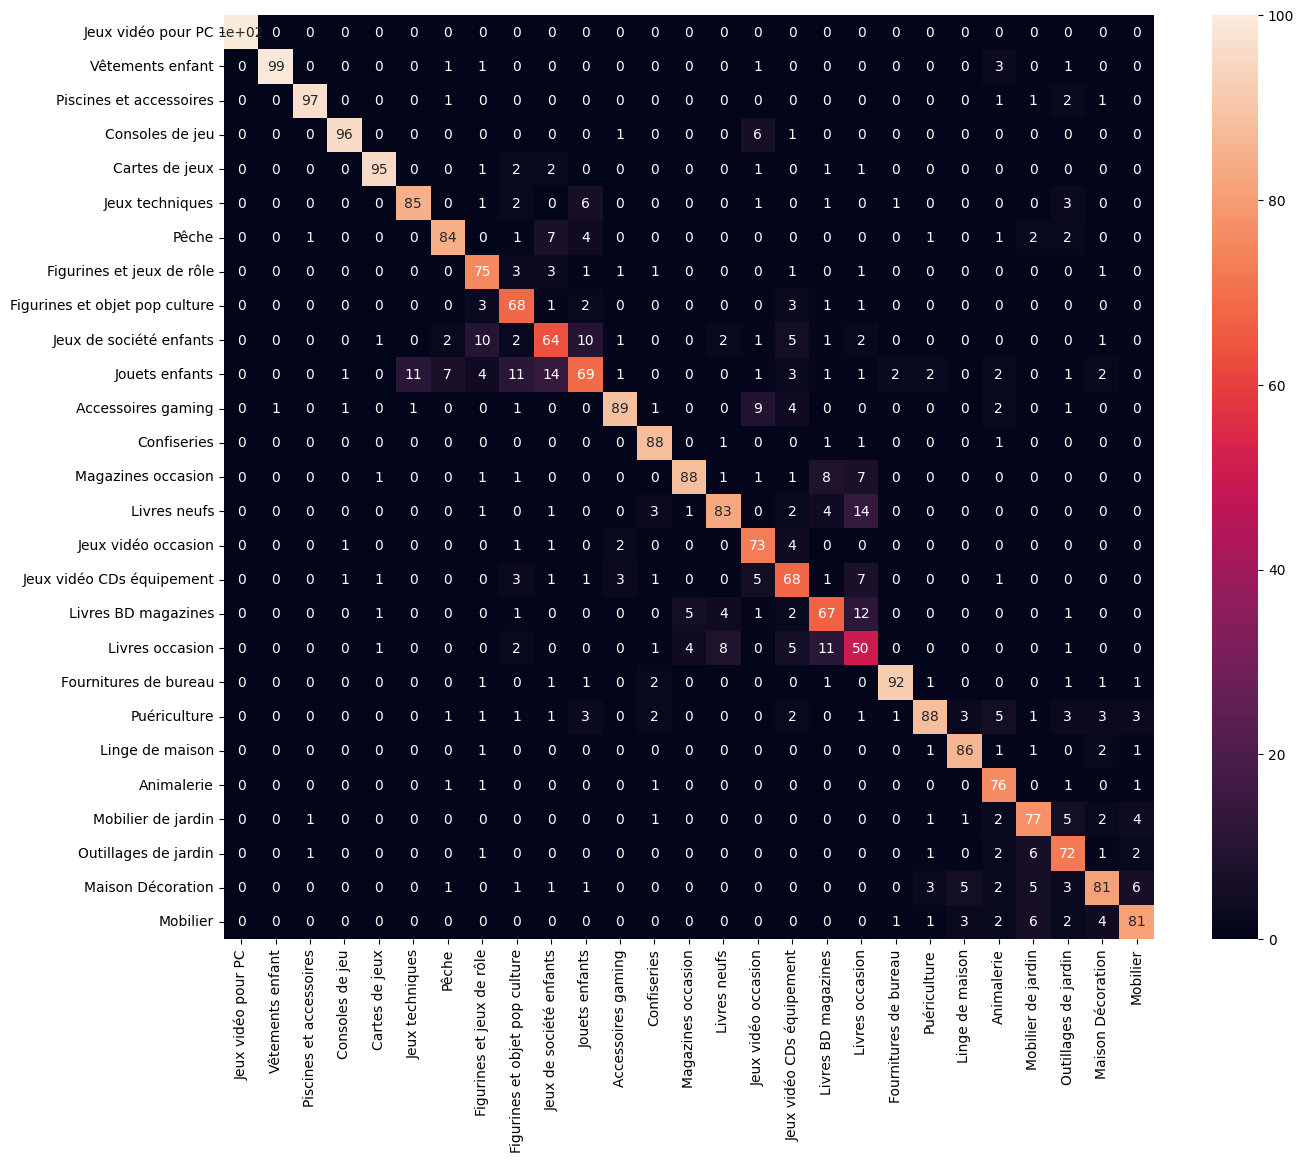

<module 'matplotlib.pyplot' from 'c:\\Users\\justj\\.conda\\envs\\Rakuten\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [123]:
test_pred = model.predict(X_test)
test_pred_class = np.argmax(test_pred, axis=1)
plot_classification_results(y_test_class, test_pred_class, index=encoder.classes_)

In [124]:
from sklearn.metrics import f1_score

f1_score(y_test_class, test_pred_class, average='weighted')

0.8138061671714937

## SVM on top of deep netowrk layers

### using outputs of dense layers

In [125]:
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[5].output)
X_train_model = intermediate_layer_model.predict(X_train)
X_test_model = intermediate_layer_model.predict(X_test)

531/531 [==============================] - 4s 7ms/step


In [126]:
X_train_model.shape

(67932, 64)

In [132]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

svc = LinearSVC(penalty='l1', C=1, random_state=123, dual='auto')
svc.fit(X_train_model, y_train_class);
test_pred_svc = svc.predict(X_test_model)
f1_score(y_test_class, test_pred_svc, average='weighted')
#plot_classification_results(y_test_class, test_pred_svc, index=encoder.classes_)


In [138]:
import xgboost as xgb

gbc = xgb.XGBClassifier(objective='multi:softprob',max_depth=6, reg_alpha=0, n_estimators=200)
gbc.fit(X_train_model, y_train_class)
test_pred_gbc = gbc.predict(X_test_model)

f1_score(y_test_class, test_pred_gbc, average='weighted')

0.8099305036329799

### Using output of embedding layers, after average pooling across tokens

In [74]:
from keras.layers import GlobalAveragePooling1D

inputs = model.input
x = model.layers[0].output
x = model.layers[1](x)
avg_outputs = GlobalAveragePooling1D()(x)

intermediate_layer_model = Model(inputs=inputs, outputs=avg_outputs)

X_train_model = intermediate_layer_model.predict(X_train)
X_test_model = intermediate_layer_model.predict(X_test)

531/531 [==============================] - 2s 4ms/step


In [127]:
X_test_model.shape

(16984, 64)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import xgboost as xgb

svc = LinearSVC(penalty='l1', C=1, random_state=123, dual='auto')
svc.fit(X_train_model, y_train_class);
test_pred_svc = svc.predict(X_test_model)
f1_score(y_test_class, test_pred_svc, average='weighted')
#plot_classification_results(y_test_class, test_pred_svc, index=encoder.classes_)